### 주제: 건설 장비 내부 기계 부품의 마모 상태 및 윤활 성능을 오일 데이터 분석을 통해 확인하고, AI를 활용한 분류 모델 개발을 통해 적절한 교체 주기를 파악

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV

데이터 분석 목표: 샘플 오일 관련 부품 정보를 분석해 오일 정상 여부 예측

In [2]:
train = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/train.csv')
test_df = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/test.csv')
submission = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/sample_submission.csv')

In [14]:
test_df.columns

Index(['ID', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX',
       'TI', 'V', 'V40', 'ZN', 'CR_flag', 'CU_flag', 'FE_flag', 'H2O_flag',
       'NI_flag', 'TI_flag', 'V_flag', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009',
       'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014',
       'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019',
       'YEAR_2020', 'YEAR_2021', 'YEAR_2022', 'COMPONENT_ARBITRARY_COMPONENT1',
       'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3',
       'COMPONENT_ARBITRARY_COMPONENT4', 'ANONYMOUS_SUM'],
      dtype='object')

In [4]:
columns = ['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN','Y_LABEL']

변수 정보   
ANONYMOUS_1 - 무명 Feature 1. 수치형 데이터   
ANONYMOUS_2 - 무명 Feature 2. 수치형 데이터   
AG, CO, CR, FE, H2O, MN, MO, NI, TI, V, ZN - 원소기호   
V40 - 40도에서 측정한 액체의 점도   
YEAR - 오일샘플 및 진단 해(Year)    
PQINDEX(Particle Quantifier Index) : Particle Quantifier Index(PQ Index), 또는 PQI라고도 불리는 이 지표는 입자의 크기와 상관없이 윤활유 샘플 내에 존재하는 전체 강자성 물질(자성을 띤 금속 입자)의 양을 측정하는 방법이다.
이 지표는 마모로 인한 문제가 발생할 가능성을 조기에 감지하기 위한 선별 검사 도구로 사용되며, 예지 보전(predictive maintenance) 프로그램에서 자주 활용된다.    

Y_LABEL - 타깃변수로 0일 때 정상, 1일 때 비정상


train 데이터에는 존재하나 test 데이터에는 없는 변수들 존재했었다. 이는 모델 학습 시 사용할 수 없는 변수들이기 때문에 제거해주었다.    

In [5]:
train_df = train[columns]

In [17]:
train_df['COMPONENT_ARBITRARY'].value_counts()

COMPONENT_ARBITRARY
COMPONENT3    7050
COMPONENT1    3890
COMPONENT2    2316
COMPONENT4     839
Name: count, dtype: int64

부품 종류로는 4개가 있으며 1은 3890개, 2는 2316개, 3은 7050개, 4는 839개씩 있다.    

In [125]:
# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 개수
count = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)

개수:
 Y_LABEL                 0     1
COMPONENT_ARBITRARY            
COMPONENT1           3500   390
COMPONENT2           1915   401
COMPONENT3           4906  2144
COMPONENT4            750    89

비율:
 Y_LABEL                     0         1
COMPONENT_ARBITRARY                    
COMPONENT1           0.899743  0.100257
COMPONENT2           0.826857  0.173143
COMPONENT3           0.695887  0.304113
COMPONENT4           0.893921  0.106079


COMPONENT_ARBITRARY별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 COMPONENT 2와 3에서 이상 오일 비율이 높게 나온 것을 확인할 수 있었다.    
이상 샘플이 Component 3에서 차지하는 비율이 0.3으로 다른 Component에 비해 높게 나온 것을 확인

In [126]:
# YEAR별 Y_LABEL의 0,1 개수
count = train_df.groupby('YEAR')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# YEAR별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('YEAR')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)

개수:
 Y_LABEL     0    1
YEAR              
2007      236   92
2008     1062  357
2009      681  268
2010      639  227
2011      910  236
2012      849  224
2013      949  240
2014     1133  267
2015      935  221
2016      771  171
2017      740  156
2018      699  179
2019      520  129
2020      275   98
2021      381   96
2022      291   63

비율:
 Y_LABEL         0         1
YEAR                       
2007     0.719512  0.280488
2008     0.748414  0.251586
2009     0.717597  0.282403
2010     0.737875  0.262125
2011     0.794066  0.205934
2012     0.791240  0.208760
2013     0.798150  0.201850
2014     0.809286  0.190714
2015     0.808824  0.191176
2016     0.818471  0.181529
2017     0.825893  0.174107
2018     0.796128  0.203872
2019     0.801233  0.198767
2020     0.737265  0.262735
2021     0.798742  0.201258
2022     0.822034  0.177966


YEAR별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 특정 연도에서 비정상 비율이 높게 나온 것을 확인할 수 있었다

In [127]:
train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)

# 평균값을 표로 보기 좋게 출력
mean_df = train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)
display(mean_df)

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
COMPONENT_ARBITRARY,,,,,,,,,,,,,,,,,,
COMPONENT1,-0.986054,2013.729563,-0.959173,0.025193,0.014396,1.910540,9.929563,27.057069,0.002699,0.514910,69.364267,0.152185,20.422622,0.055013,0.024422,102.678103,1161.010283,0.100257
COMPONENT2,-0.986206,2013.718912,-0.961256,0.024180,0.009499,0.515976,56.677029,18.890328,0.003282,0.155872,0.652418,0.027634,27.230570,0.032815,0.010794,52.720695,505.785838,0.173143
COMPONENT3,-0.984818,2013.494043,-0.961531,0.028227,0.044397,5.361986,32.252057,332.500426,0.064525,5.137163,3.415745,1.362553,807.300567,1.372908,0.082837,136.411370,241.379574,0.304113
COMPONENT4,-0.984588,2014.443385,-0.953130,0.013111,0.007151,0.091776,107.109654,21.651967,0.001549,0.852205,50.958284,0.034565,21.091776,0.010727,0.011919,69.310012,1081.669845,0.106079


COMPONENT를 기준으로 데이터를 그룹화하여 변수 분포를 확인해봤을 때 확실히 분포의 차이가 있었다.

ANONYMOUS_1 과 ANONYMOUS_2는 더해서 하나의 변수로 만들어주었다.

In [6]:
# ANONYMOUS_1 과 ANONYMOUS_2 더해서 새로운 피처 생성
train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']

# ANONYMOUS_1, ANONYMOUS_2 제거
train_df = train_df.drop(columns=['ANONYMOUS_1', 'ANONYMOUS_2'])

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_27580\1612360360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']


In [129]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats = train_df.groupby(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']).median(numeric_only=True)
grouped_stats

AG   CO   CR    CU    FE  H2O   MN     MO  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                               
COMPONENT1          2007 0        0.0  0.0  2.0   3.0  23.5  0.0  1.0   21.0   
                         1        0.0  0.0  3.0  22.0  47.0  0.0  1.0  104.0   
                    2008 0        0.0  0.0  1.0   4.0  21.0  0.0  1.0   37.0   
                         1        0.0  0.0  4.0   9.0  51.5  0.0  1.0   99.0   
                    2009 0        0.0  0.0  2.0   4.0  24.0  0.0  1.0   37.0   
...                               ...  ...  ...   ...   ...  ...  ...    ...   
COMPONENT4          2020 1        0.0  0.0  0.0  17.5  44.0  0.0  1.5   22.0   
                    2021 0        0.0  0.0  0.0   0.0  11.0  0.0  0.0    2.0   
                         1        0.0  0.0  0.0   5.5  54.5  0.0  0.0    5.5   
                    2022 0        0.0  0.0  0.0   1.0  11.0  0.0  0.0   20.0   
                         1        0.0  0.0  0.0   1.0  11.0  0.0  0.0   25.0   

                                   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                           
COMPONENT1          2007 0        0.0     17.0  0.0  0.0  101.30  1208.5   
                         1        0.0     18.0  0.0  0.0  112.60  1280.0   
                    2008 0        0.0     14.0  0.0  0.0  105.30  1225.0   
                         1        1.0     17.0  0.0  0.0  109.25  1278.0   
                    2009 0        0.0     12.0  0.0  0.0  103.20  1183.0   
...                               ...      ...  ...  ...     ...     ...   
COMPONENT4          2020 1        0.0     48.0  0.0  0.0   53.35   480.5   
                    2021 0        0.0     11.0  0.0  0.0   71.40  1038.0   
                         1        0.0     25.0  0.0  0.0   64.00  1109.0   
                    2022 0        0.0      8.0  0.0  0.0   70.40  1077.0   
                         1        0.0     10.0  0.0  0.0   59.80  1162.0   

                                  ANONYMOUS_SUM  
COMPONENT_ARBITRARY YEAR Y_LABEL                 
COMPONENT1          2007 0            -1.953617  
                         1            -1.960353  
                    2008 0            -1.958369  
                         1            -1.928166  
                    2009 0            -1.988598  
...                                         ...  
COMPONENT4          2020 1            -1.958085  
                    2021 0            -1.904710  
                         1            -1.977001  
                    2022 0            -1.912576  
                         1            -1.894914  

[127 rows x 15 columns]

In [130]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats2 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).mean(numeric_only=True)
grouped_stats2

YEAR        AG        CO         CR  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        2013.795429  0.023143  0.014571   1.378000   
                    1        2013.138462  0.043590  0.012821   6.689744   
COMPONENT2          0        2013.817755  0.025587  0.007833   0.401044   
                    1        2013.246883  0.017456  0.017456   1.064838   
COMPONENT3          0        2013.614757  0.024868  0.023848   1.779250   
                    1        2013.217817  0.035914  0.091418  13.560168   
COMPONENT4          0        2014.441333  0.013333  0.004000   0.076000   
                    1        2014.460674  0.011236  0.033708   0.224719   

                                     CU          FE       H2O         MN  \
COMPONENT_ARBITRARY Y_LABEL                                                
COMPONENT1          0          8.921714   22.762571  0.001571   0.450571   
                    1         18.974359   65.597436  0.012821   1.092308   
COMPONENT2          0         52.925849   13.013055  0.001097   0.096606   
                    1         74.591022   46.957606  0.013716   0.438903   
COMPONENT3          0         19.878516  156.025275  0.004260   2.804525   
                    1         60.565765  736.319030  0.202425  10.474813   
COMPONENT4          0        107.133333   19.585333  0.001200   0.644000   
                    1        106.910112   39.067416  0.004494   2.606742   

                                    MO        NI      PQINDEX        TI  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        69.089429  0.102286    12.703143  0.020571   
                    1        71.830769  0.600000    89.700000  0.364103   
COMPONENT2          0         0.572324  0.023499    13.025065  0.021932   
                    1         1.034913  0.047382    95.069825  0.084788   
COMPONENT3          0         2.704240  0.622503   316.359967  0.135956   
                    1         5.043843  3.055970  1930.693563  4.203358   
COMPONENT4          0        52.713333  0.034667    16.044000  0.009333   
                    1        36.168539  0.033708    63.629213  0.022472   

                                    V         V40           ZN  ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                                                    
COMPONENT1          0        0.021429  102.497291  1160.656571      -1.945416  
                    1        0.051282  104.300769  1164.184615      -1.943537  
COMPONENT2          0        0.012533   52.290501   518.969191      -1.946706  
                    1        0.002494   54.775112   442.827930      -1.951072  
COMPONENT3          0        0.023848  134.057440   260.599674      -1.946695  
                    1        0.217817  141.797743   197.399254      -1.945556  
COMPONENT4          0        0.013333   69.785867  1096.238667      -1.938453  
                    1        0.000000   65.300000   958.898876      -1.931529

In [131]:
# Component와 Y_LABEl로 그룹화하여 각 변수의 평균값을 확인
grouped_stats3 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).median(numeric_only=True)
grouped_stats3

YEAR   AG   CO   CR    CU     FE  H2O   MN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        2014.0  0.0  0.0  1.0   3.0   18.0  0.0  0.0   
                    1        2013.0  0.0  0.0  3.0   7.0   43.5  0.0  1.0   
COMPONENT2          0        2014.0  0.0  0.0  0.0  11.0    5.0  0.0  0.0   
                    1        2013.0  0.0  0.0  0.0  21.0   14.0  0.0  0.0   
COMPONENT3          0        2014.0  0.0  0.0  1.0   4.0   96.0  0.0  1.0   
                    1        2013.0  0.0  0.0  4.0   5.0  379.0  0.0  5.0   
COMPONENT4          0        2014.0  0.0  0.0  0.0   5.0   16.0  0.0  0.0   
                    1        2014.0  0.0  0.0  0.0  21.0   23.0  0.0  0.0   

                               MO   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        20.0  0.0     11.0  0.0  0.0  100.50  1148.0   
                    1        34.0  0.0     17.0  0.0  0.0  102.95  1170.5   
COMPONENT2          0         0.0  0.0     11.0  0.0  0.0   47.10   566.0   
                    1         0.0  0.0     30.0  0.0  0.0   53.00   445.0   
COMPONENT3          0         0.0  0.0    106.0  0.0  0.0  136.50    38.0   
                    1         1.0  1.0    744.0  0.0  0.0  138.40    38.0   
COMPONENT4          0        10.5  0.0     15.0  0.0  0.0   70.65  1131.0   
                    1         8.0  0.0     25.0  0.0  0.0   68.20  1107.0   

                             ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                 
COMPONENT1          0            -1.979308  
                    1            -1.978154  
COMPONENT2          0            -1.978818  
                    1            -1.982075  
COMPONENT3          0            -1.976357  
                    1            -1.975860  
COMPONENT4          0            -1.977908  
                    1            -1.972581

In [132]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats4 = train_df.groupby(['COMPONENT_ARBITRARY','YEAR']).median(numeric_only=True)
grouped_stats4

AG   CO   CR   CU    FE  H2O   MN    MO   NI  \
COMPONENT_ARBITRARY YEAR                                                  
COMPONENT1          2007  0.0  0.0  2.0  4.0  24.0  0.0  1.0  31.0  0.0   
                    2008  0.0  0.0  2.0  5.0  23.0  0.0  1.0  43.0  0.0   
                    2009  0.0  0.0  2.0  5.0  26.0  0.0  1.0  36.0  0.0   
                    2010  0.0  0.0  2.0  4.0  22.0  0.0  0.0  49.0  0.0   
                    2011  0.0  0.0  1.0  3.0  20.0  0.0  0.0  40.0  0.0   
...                       ...  ...  ...  ...   ...  ...  ...   ...  ...   
COMPONENT4          2018  0.0  0.0  0.0  3.0  14.0  0.0  0.0   2.0  0.0   
                    2019  0.0  0.0  0.0  5.0  29.0  0.0  0.0   2.0  0.0   
                    2020  0.0  0.0  0.0  2.0  12.5  0.0  0.0   5.5  0.0   
                    2021  0.0  0.0  0.0  1.0  11.0  0.0  0.0   2.0  0.0   
                    2022  0.0  0.0  0.0  1.0  11.0  0.0  0.0  20.0  0.0   

                          PQINDEX   TI    V     V40      ZN  Y_LABEL  \
COMPONENT_ARBITRARY YEAR                                               
COMPONENT1          2007     17.0  0.0  0.0  103.90  1223.0      0.0   
                    2008     14.0  0.0  0.0  105.60  1231.0      0.0   
                    2009     13.0  0.0  0.0  103.40  1189.0      0.0   
                    2010     11.0  0.0  0.0  106.80  1168.0      0.0   
                    2011     11.0  0.0  0.0  102.50  1163.0      0.0   
...                           ...  ...  ...     ...     ...      ...   
COMPONENT4          2018     15.0  0.0  0.0   70.40  1125.0      0.0   
                    2019     20.0  0.0  0.0   65.00   971.0      0.0   
                    2020     12.5  0.0  0.0   68.35  1038.5      0.0   
                    2021     12.0  0.0  0.0   70.80  1050.0      0.0   
                    2022      8.5  0.0  0.0   69.65  1077.5      0.0   

                          ANONYMOUS_SUM  
COMPONENT_ARBITRARY YEAR                 
COMPONENT1          2007      -1.955793  
                    2008      -1.957034  
                    2009      -1.988073  
                    2010      -1.990349  
                    2011      -1.990165  
...                                 ...  
COMPONENT4          2018      -1.980515  
                    2019      -1.962249  
                    2020      -1.922993  
                    2021      -1.915651  
                    2022      -1.911790  

[64 rows x 16 columns]

In [133]:
# Y_LABEL로 그룹화하여 각 변수의 평균값을 확인
grouped_stats5 = train_df.groupby(['Y_LABEL']).median(numeric_only=True)
grouped_stats5

,YEAR,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,ANONYMOUS_SUM
Y_LABEL,,,,,,,,,,,,,,,,
0,2014.0,0.0,0.0,1.0,4.0,30.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,105.4,662.0,-1.978150
1,2013.0,0.0,0.0,3.0,6.0,207.5,0.0,3.0,1.0,0.0,382.0,0.0,0.0,130.9,83.0,-1.976511


Component, Year, Y_LABEL와 같은 범주형 변수에 따라서 변수의 분포가 다르게 형성되어있는 것을 알게 되었다.    
그러므로 Component, Year 변수를 label encoding 작업을 해서 사용하면 분류 성능을 높일 수 있을 것으로 판단했다.

## Optuna 튜닝용 모델 학습 함수

In [135]:
# Optuna 튜닝용 objective 함수 예시 (각 모델별)

# random forest
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# gradient boosting
def gb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# lightgbm
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# extra trees
def extratrees_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# catboost
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# adaboost
def adaboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'random_state': 42
    }
    model = AdaBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# xgboost
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

## EDA

In [136]:
# Y_LABEL이 0과 1인 데이터 각각 추출
df_0 = train_df[train_df['Y_LABEL'] == 0]
df_1 = train_df[train_df['Y_LABEL'] == 1]

# 주요 변수별 평균 비교
mean_0 = df_0.mean(numeric_only=True)
mean_1 = df_1.mean(numeric_only=True)
diff = pd.DataFrame({'Y_LABEL=0': mean_0, 'Y_LABEL=1': mean_1})

display(diff)

# 주요 변수별 중앙값 비교
median_0 = df_0.median(numeric_only=True)
median_1 = df_1.median(numeric_only=True)
median_diff = pd.DataFrame({'Y_LABEL=0': median_0, 'Y_LABEL=1': median_1})

display(median_diff)

,Y_LABEL=0,Y_LABEL=1
YEAR,2013.762984,2013.248016
AG,0.023665,0.033730
CO,0.016801,0.069775
CR,1.298618,10.624669
CU,28.042002,58.425595
FE,79.914913,537.882937
H2O,0.002656,0.147123
MN,1.445579,7.702381
MO,26.710415,14.041667
NI,0.314606,2.251323


,Y_LABEL=0,Y_LABEL=1
YEAR,2014.00000,2013.000000
AG,0.00000,0.000000
CO,0.00000,0.000000
CR,1.00000,3.000000
CU,4.00000,6.000000
FE,30.00000,207.500000
H2O,0.00000,0.000000
MN,0.00000,3.000000
MO,1.00000,1.000000
NI,0.00000,0.000000


In [137]:
num_cols = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL', 'YEAR']]

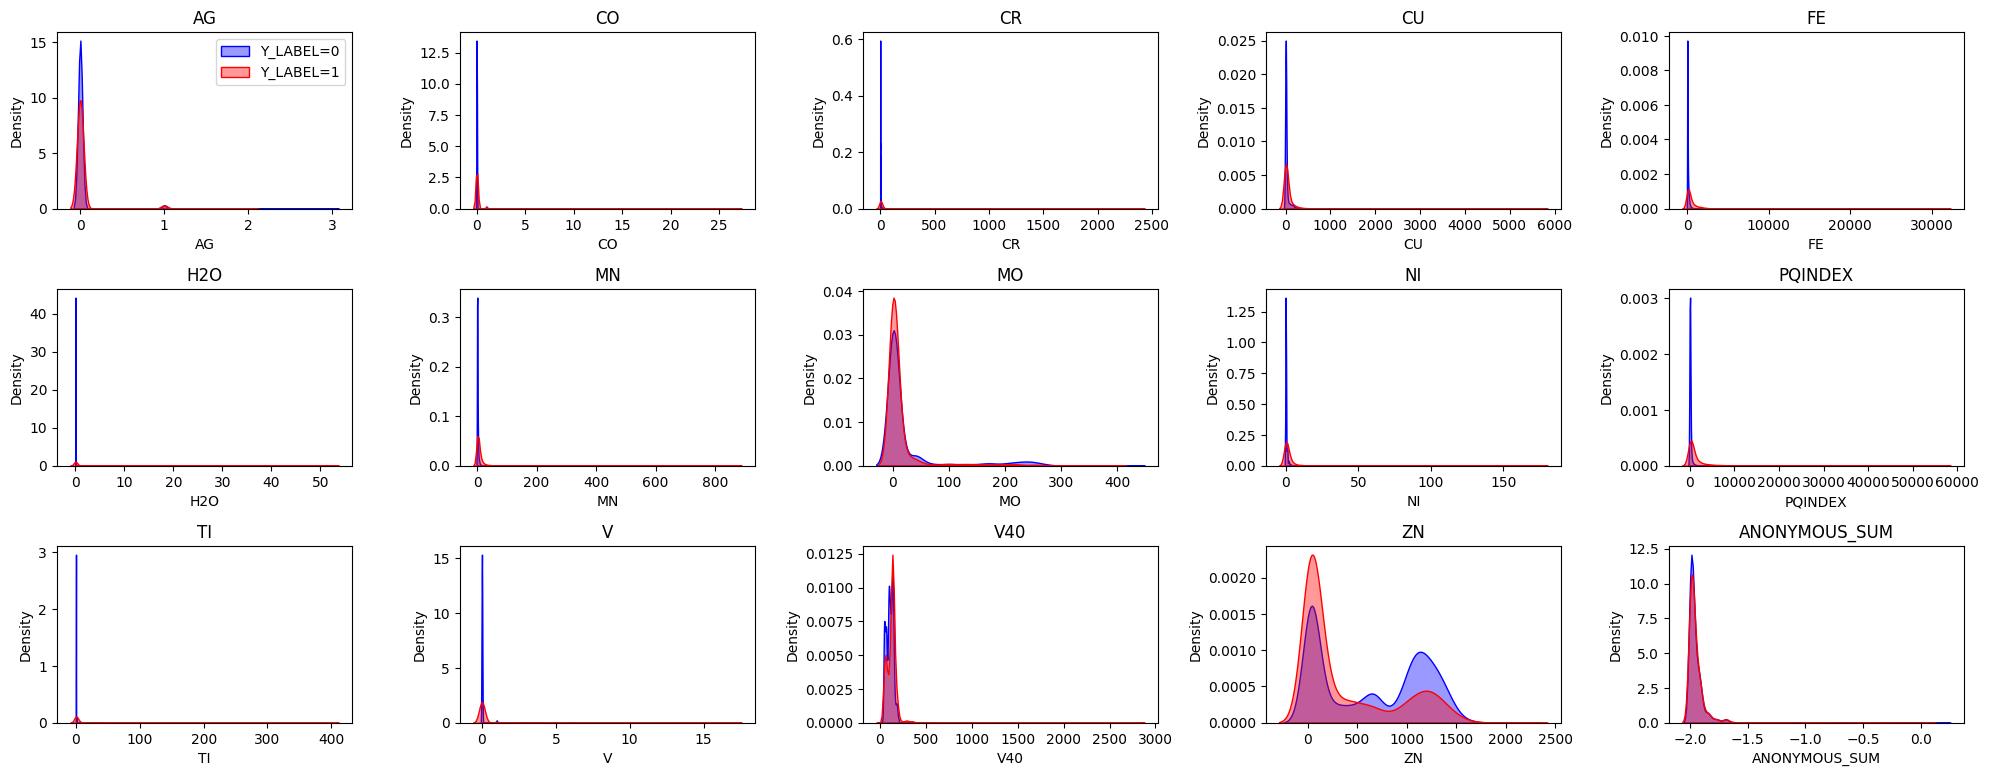

In [138]:
plt.figure(figsize=(20, 10))
for var in num_cols:
  plt.subplot(4, 5, num_cols.index(var)+1)
  sns.kdeplot(df_0[var], label='Y_LABEL=0', color='blue', fill=True, alpha=0.4)
  sns.kdeplot(df_1[var], label='Y_LABEL=1', color='red', fill=True, alpha=0.4)
  plt.title(var)
  plt.xlabel(var)
  plt.ylabel('Density')
  if num_cols.index(var) == 0:
    plt.legend()
plt.tight_layout()
plt.show()

변수의 분포를 시각적으로 보았을 때는 Y_LABEL이 0일 때 평균에 몰려있는 것을 알 수 있었다. 즉, Y_LABEL이 1일 때 분산이 더 크다고 할 수 있다.

In [139]:
# 주요 변수별 첨도(kurtosis)와 왜도(skewness) 계산
# independent_vars 정의 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL', 'YEAR']]

kurt_skew = []
for col in independent_vars:
  kurt_0 = kurtosis(df_0[col], nan_policy='omit')
  skew_0 = skew(df_0[col], nan_policy='omit')
  kurt_1 = kurtosis(df_1[col], nan_policy='omit')
  skew_1 = skew(df_1[col], nan_policy='omit')
  kurt_skew.append({
    '변수': col,
    'Y_LABEL=0_첨도': kurt_0,
    'Y_LABEL=0_왜도': skew_0,
    'Y_LABEL=1_첨도': kurt_1,
    'Y_LABEL=1_왜도': skew_1
  })

kurt_skew_df = pd.DataFrame(kurt_skew)
display(kurt_skew_df)

,변수,Y_LABEL=0_첨도,Y_LABEL=0_왜도,Y_LABEL=1_첨도,Y_LABEL=1_왜도
0,AG,67.813133,7.714872,41.829436,6.202117
1,CO,540.886887,19.202058,1475.641160,33.511398
2,CR,26.453412,3.757484,857.886267,25.678334
3,CU,60.936285,6.194518,288.514628,14.790073
4,FE,43.043956,5.337027,280.904281,11.513536
5,H2O,3503.186360,51.761273,587.424511,22.624226
6,MN,211.387324,12.212082,890.504258,23.809971
7,MO,5.988128,2.678437,18.851909,4.227405
8,NI,563.688954,18.771974,185.809482,11.278651
9,PQINDEX,272.546362,14.253711,59.717628,5.440568


첨도는 분포의 뾰족함 정도를 수치를 나타낸 지표이다.   
0에 가까울 수록 정규분포와 유사해지고, 값이 클수록 극단값이 많다는 뜻이다.    
왜도는 분포의 비대칭 정도를 나타낸 지표이다.    
0이면 대칭, 양수이면 오른쪽 꼬리가 음수면 왼쪽 꼬리가 더 길다는 뜻이다.   

대부분 변수의 첨도와 왜도가 매우 크다.    
→ 극단값(이상치)이 많고, 분포가 비대칭임을 의미한다.  

CO, CR, CU, FE, H2O, MN, NI, PQINDEX, TI, V, V40, ANONYMOUS_SUM 등    
→ 첨도와 왜도가 모두 10~1000 이상으로, 정규분포와 매우 다르다.        
→ 특히 CO, CR, FE, H2O, TI 등은 비정상(Y_LABEL=1)에서 첨도와 왜도가 더 크다(극단값이 더 많고, 오른쪽 꼬리가 더 김).   

ZN    
→ 첨도와 왜도가 0에 가까워 분포가 비교적 대칭적이고 극단값이 적음.    

ANONYMOUS_SUM   
→ 두 그룹 모두 첨도와 왜도가 비슷(극단값과 비대칭 정도가 비슷).


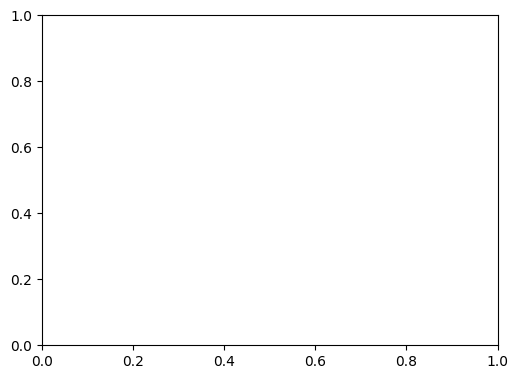

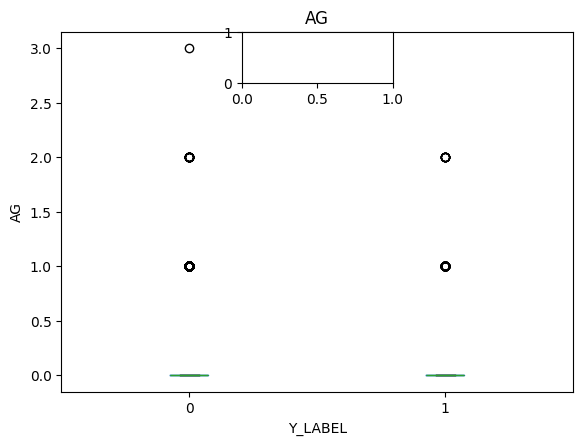

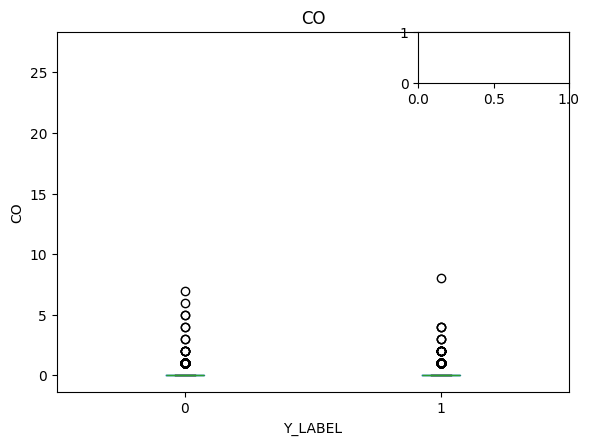

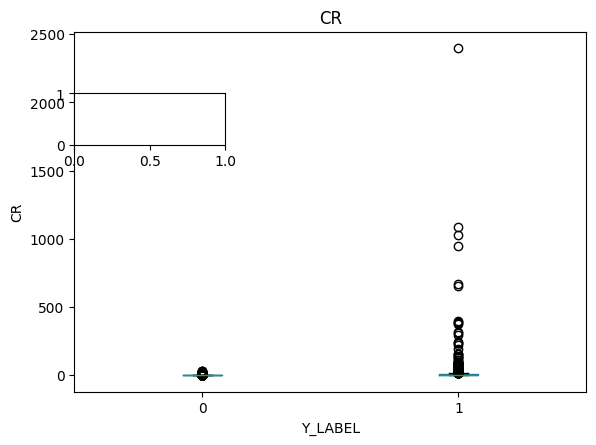

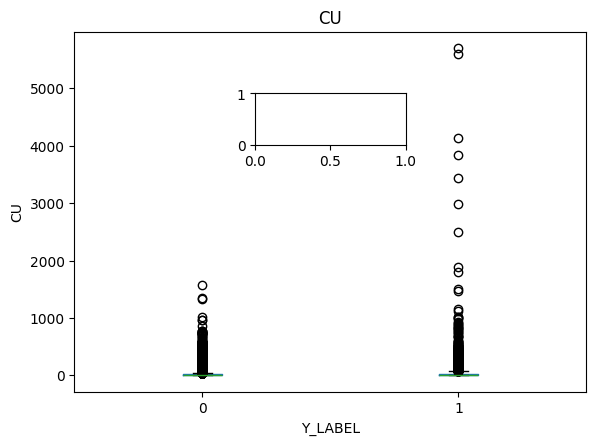

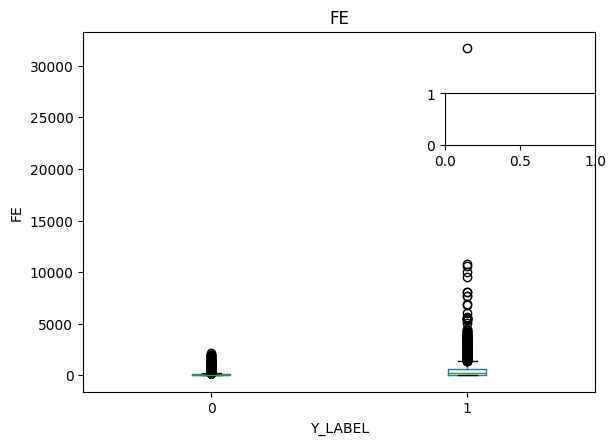

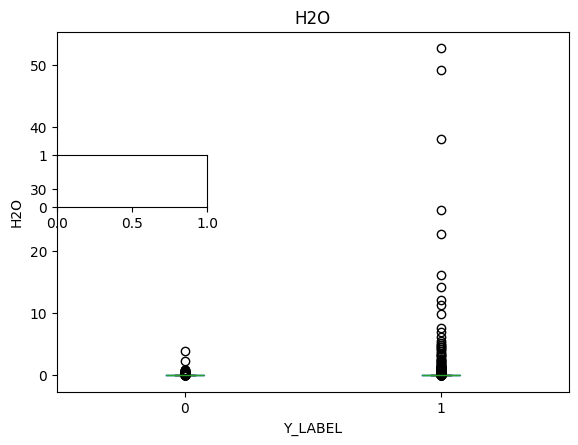

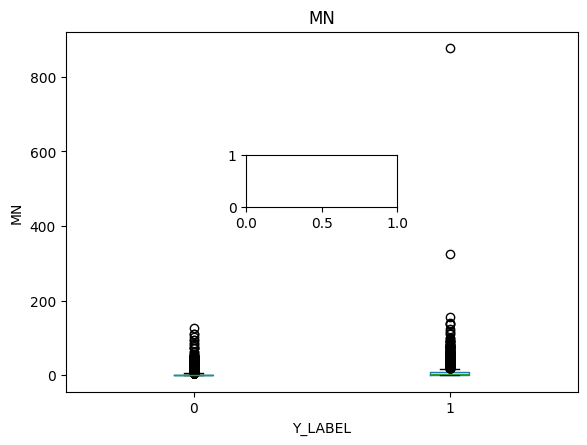

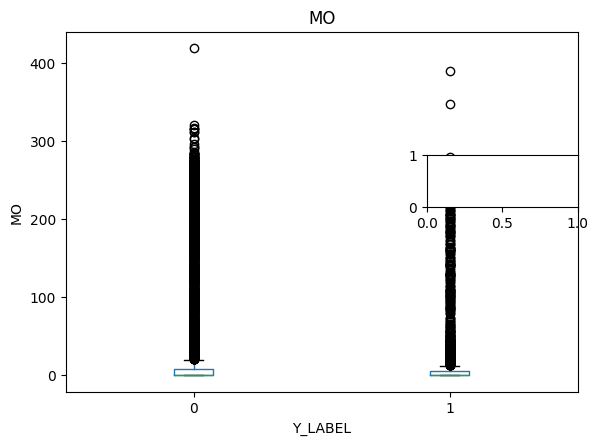

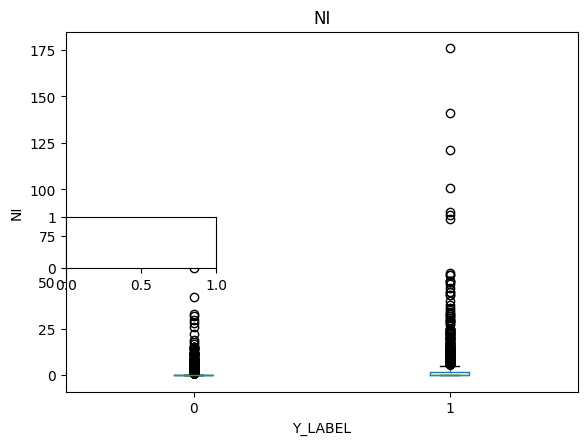

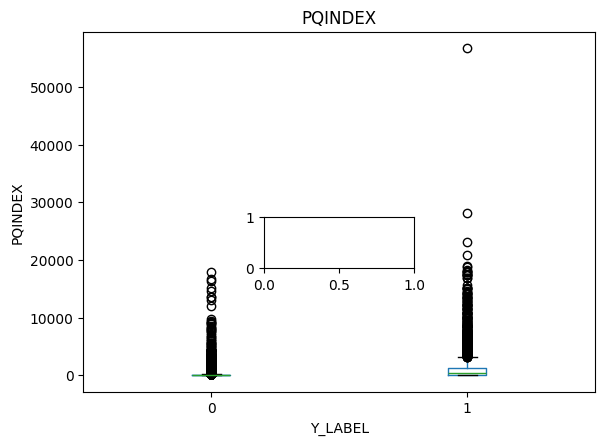

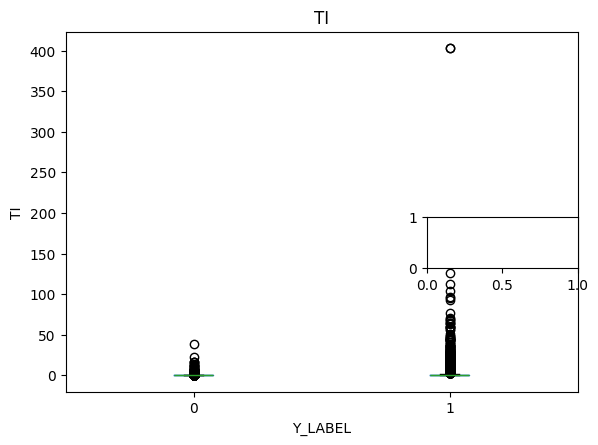

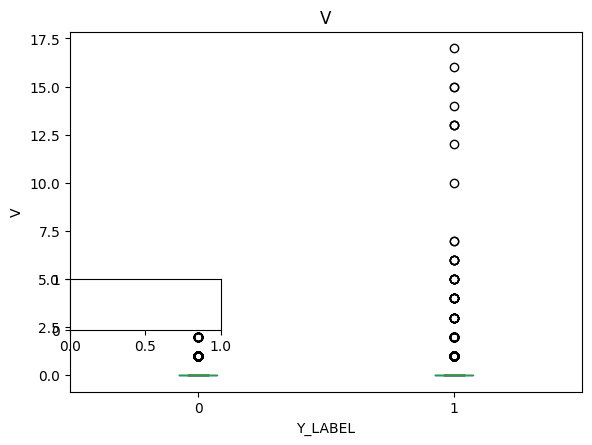

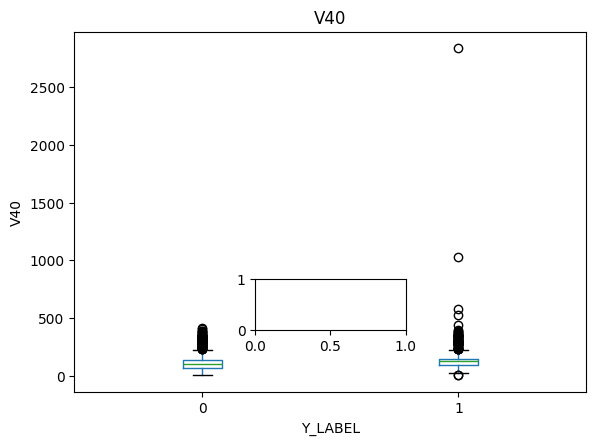

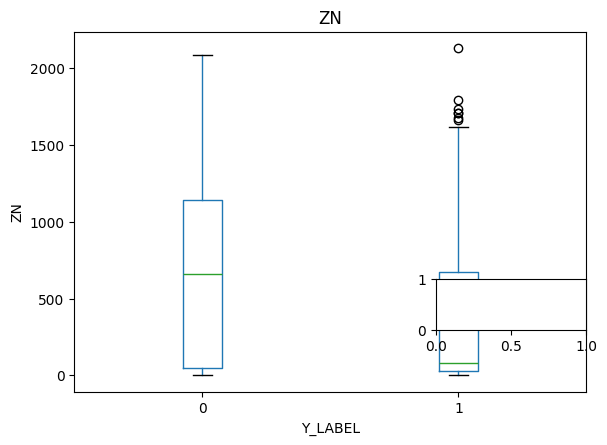

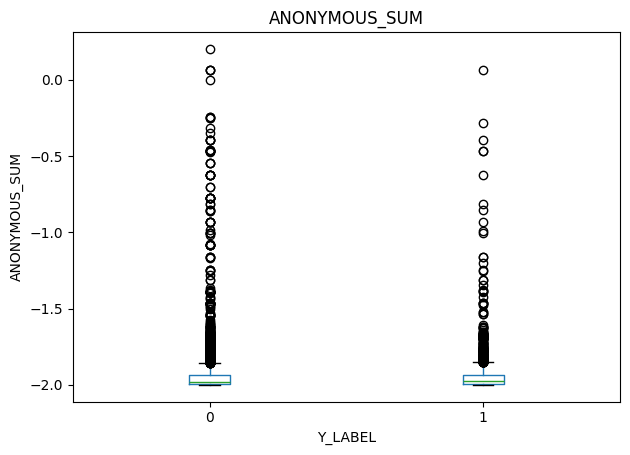

In [140]:
# 변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY, YEAR 제외)
plot_vars = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR','Y_LABEL']]

plt.figure(figsize=(20, 30))
for i, var in enumerate(plot_vars):
  plt.subplot(6, 3, i+1)
  train_df.boxplot(column=var, by='Y_LABEL', grid=False)
  plt.title(var)
  plt.suptitle('')
  plt.xlabel('Y_LABEL')
  plt.ylabel(var)
plt.tight_layout()
plt.show()

Boxplot으로 Y_LABEL이 0, 1일 때의 분포를 확인해보았다.    
일부 변수들에서 Y_LABEL이 1일 때 outlier를 발견했다.    
이를 분류해낼 수 있는 파생변수를 만들었다.    

In [141]:
train_df

,ID,COMPONENT_ARBITRARY,YEAR,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL,ANONYMOUS_SUM
0,TRAIN_00000,COMPONENT3,2011,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,1,-1.996688
1,TRAIN_00001,COMPONENT2,2021,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0,-1.960578
2,TRAIN_00002,COMPONENT2,2015,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,0,-1.990356
3,TRAIN_00003,COMPONENT3,2010,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0,-1.956456
4,TRAIN_00004,COMPONENT3,2015,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0,-1.979867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,2014,0,0,0,3,23,0.0,0,0,0,35,0,0,135.4,16,0,-1.995802
14091,TRAIN_14091,COMPONENT1,2013,0,0,0,2,12,0.0,0,224,0,9,0,0,117.5,1408,0,-1.987841
14092,TRAIN_14092,COMPONENT3,2008,0,0,4,7,415,0.0,7,10,1,645,0,0,54.0,1301,0,-1.920555
14093,TRAIN_14093,COMPONENT2,2009,0,0,0,170,19,0.0,0,1,0,11,0,0,44.3,652,0,-1.915716


In [142]:
# COMPONENT1 데이터에서 독립변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 결과 저장용
test_results = []

for col in independent_vars:
    # 두 그룹 데이터
    group0 = df_0[col]
    group1 = df_1[col]
    # 정규성, 등분산성 가정이 어려우므로 Mann-Whitney U test 사용
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    # p-value를 소수점 5자리까지만 표시
    p_rounded = round(p, 5)
    test_results.append({'변수': col, 'Mann-Whitney U 통계량': stat, 'p-value': p_rounded})

# 결과 DataFrame으로 정리
test = pd.DataFrame(test_results)
display(test.sort_values('p-value'))

,변수,Mann-Whitney U 통계량,p-value
1,CO,16158663.5,0.00000
2,CR,8286134.5,0.00000
3,CU,14424718.0,0.00000
4,FE,7084439.0,0.00000
5,H2O,15353329.5,0.00000
6,MN,8223702.0,0.00000
8,NI,11172343.0,0.00000
9,PQINDEX,6541285.5,0.00000
10,TI,12255029.0,0.00000
11,V,15871719.0,0.00000


대부분의 변수는 정상/비정상 그룹 간 분포 차이가 매우 유의미하다.    
→ 이 변수들은 Y_LABEL 분류(정상/비정상 예측)에 중요한 역할을 할 수 있다.    

ANONYMOUS_SUM   
→ 분포 차이가 유의하지 않아 분류에 큰 영향을 주지 않을 수 있다.      

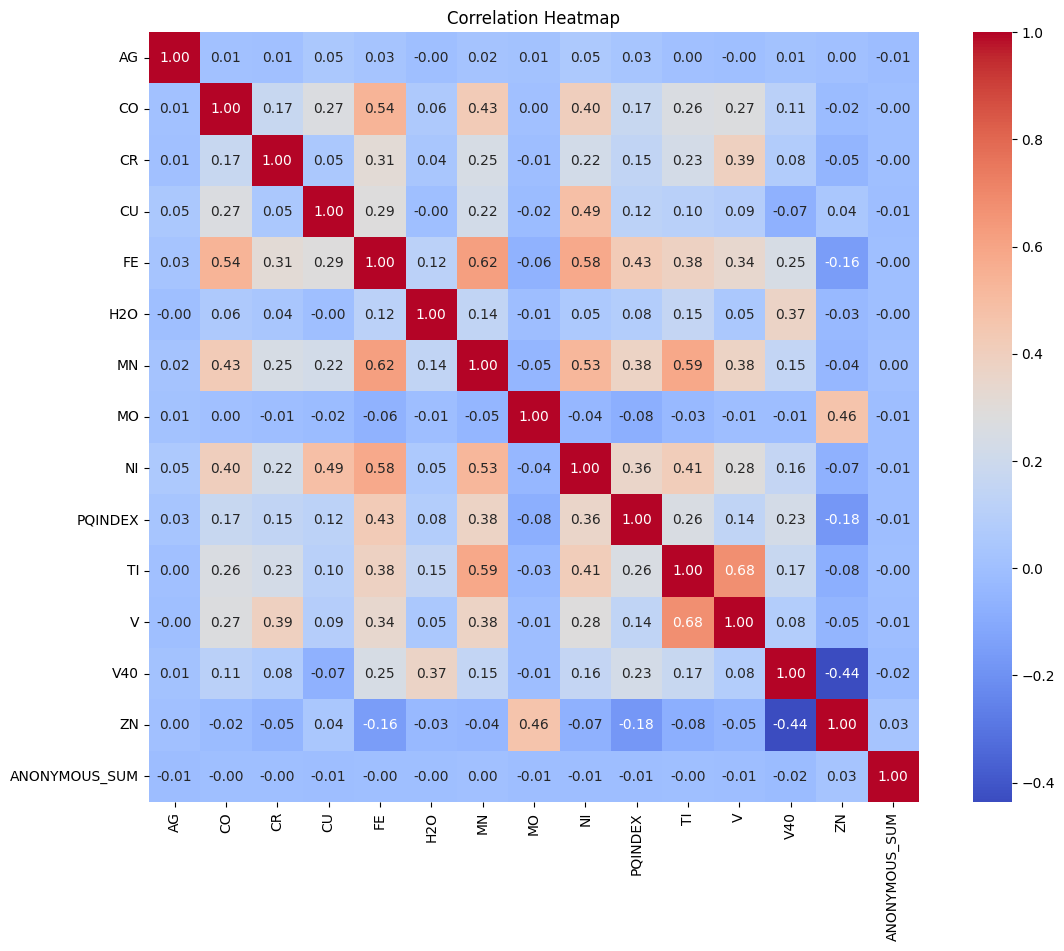

In [7]:
# 수치형 변수만 추출 (ID, COMPONENT_ARBITRARY, YEAR, Y_LABEL 등 제외)
numeric_cols = [col for col in train_df.columns if train_df[col].dtype != 'O' and col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 수치형 변수만 남긴 데이터프레임
numeric_df = train_df[numeric_cols]

# 상관관계 분석
plt.figure(figsize=(14, 10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

일반적으로 상관계수가 0.7보다 높으면 상관성이 높다고 한다. 변수들 간의 상관계수를 확인한 결과 0.7이상을 넘기지 않으므로 상관성이 높게 나오지는 않았다.    
그러므로 다중공선성 문제에 대해선 고민하지 않아도 될 것이라 판단했다.   

In [8]:
# 파생변수 생성: 각 조건을 만족하면 1, 아니면 0
train_df['CR_flag'] = (train_df['CR'] >= 300).astype(int)
train_df['CU_flag'] = (train_df['CU'] >= 2000).astype(int)
train_df['FE_flag'] = (train_df['FE'] >= 5000).astype(int)
train_df['H2O_flag'] = (train_df['H2O'] >= 8).astype(int)
train_df['NI_flag'] = (train_df['NI'] >= 75).astype(int)
train_df['TI_flag'] = (train_df['TI'] >= 50).astype(int)
train_df['V_flag'] = (train_df['V'] >= 2.5).astype(int)

### 모델링

In [145]:
train_df.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'AG', 'CO', 'CR', 'CU', 'FE',
       'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'Y_LABEL',
       'ANONYMOUS_SUM', 'CR_flag', 'CU_flag', 'FE_flag', 'H2O_flag', 'NI_flag',
       'TI_flag', 'V_flag'],
      dtype='object')

In [9]:
# 범주형 변수는 원-핫 인코딩처리
train_df = pd.get_dummies(train_df, columns=['YEAR'], prefix='YEAR')
train_df = pd.get_dummies(train_df, columns=['COMPONENT_ARBITRARY'], prefix='COMPONENT_ARBITRARY')

In [147]:
train_df.columns

train_df.head()

,ID,AG,CO,CR,CU,FE,H2O,MN,MO,NI,...,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,YEAR_2022,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4
0,TRAIN_00000,0,0,13,78,888,0.0,16,1,6,...,False,False,False,False,False,False,False,False,True,False
1,TRAIN_00001,0,0,0,31,2,0.0,0,0,0,...,False,False,False,False,True,False,False,True,False,False
2,TRAIN_00002,0,0,1,2,4,0.0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,TRAIN_00003,0,0,0,1,37,0.0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
4,TRAIN_00004,0,0,0,0,71,0.0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [10]:
# X, y 분리 (ID, COMPONENT_ARBITRARY, Y_LABEL은 제외)
X = train_df.drop(columns=['ID', 'Y_LABEL'])
y = train_df['Y_LABEL']

# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (11276, 42) (11276,)
Test shape: (2819, 42) (2819,)


In [149]:
# 여러 모델 정의
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=300, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=300, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=300, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=300, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=300, random_state=42, verbose=0)
}

results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

  results.append({
    'Model': name,
    'Accuracy': acc,
    'F1 Score': f1,
    'ROC AUC': auc
  })

results_df = pd.DataFrame(results)
display(results_df.sort_values('F1 Score', ascending=False))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2419, number of negative: 8857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 11276, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214526 -> initscore=-1.297854
[LightGBM] [Info] Start training from score -1.297854


,Model,Accuracy,F1 Score,ROC AUC
6,LightGBM,0.874424,0.683363,0.898469
1,RandomForest,0.875488,0.679452,0.903890
7,CatBoost,0.873714,0.678700,0.904570
5,XGBoost,0.871586,0.678508,0.895310
2,GradientBoosting,0.868038,0.661818,0.897712
3,ExtraTrees,0.866974,0.641834,0.891332
4,AdaBoost,0.851720,0.605660,0.869900
0,LogisticRegression,0.845335,0.519824,0.820866


모델링을 했을 시에는 LightGBM의 성능이 가장 높게 나왔다.

In [150]:
def optuna_model_train_eval(objective_func, model_class, X_train, X_test, y_train, y_test, n_trials=50, random_state=42, model_name="Model"):
    # Optuna 스터디 생성 및 최적화 실행
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)

    print(f"Best parameters ({model_name}):", study.best_params)
    print(f"Best F1 score (CV, {model_name}):", study.best_value)

    # 최적 파라미터로 모델 학습 및 테스트셋 평가
    best_model = model_class(**study.best_params, random_state=random_state)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Test Accuracy ({model_name}): {acc:.4f}")
    print(f"Test F1 Score ({model_name}): {f1:.4f}")
    print(f"Test ROC AUC ({model_name}): {auc:.4f}")

    return best_model, study

LightGBM, RandomForest, CatBoost, XGBoost, Gradient Boosting 모델에 대해서 RFECV를 사용해 최적의 변수 조합을 찾은 후, Optuna를 사용해 하이퍼파라미터 튜닝을 진행해 성능이 오르는지를 확인해보기로 했다.

### RFECV, 최적의 변수 조합 찾기

In [151]:
def rfecv_feature_selection_and_eval(model, X_train, X_test, y_train, y_test, scoring='f1', cv=5, verbose=0):
    """
    RFECV로 최적 변수 조합을 찾고, 해당 변수만 사용해 모델을 재학습 후 성능을 출력하는 함수
    model: sklearn 호환 분류기 인스턴스 (random_state, verbose 등은 미리 지정)
    """

    # RFECV로 변수 선택
    rfecv = RFECV(model, step=1, cv=cv, scoring=scoring, n_jobs=-1)
    rfecv.fit(X_train, y_train)

    print("최적 변수 개수:", rfecv.n_features_)
    selected_features = X_train.columns[rfecv.support_]
    print("최적 변수 목록:", selected_features.tolist())

    # 변수별 ranking 출력
    feature_ranking = pd.DataFrame({
        'feature': X_train.columns,
        'ranking': rfecv.ranking_,
        'selected': rfecv.support_
    }).sort_values('ranking')
    display(feature_ranking)

    # 최적 변수만 사용해서 다시 모델 학습 및 평가
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict(X_test[selected_features])
    y_proba = model.predict_proba(X_test[selected_features])[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Test Accuracy (Selected Features): {acc:.4f}")
    print(f"Test F1 Score (Selected Features): {f1:.4f}")
    print(f"Test ROC AUC (Selected Features): {auc:.4f}")

    return model, selected_features, rfecv

In [152]:
# Lightgbm 모델을 사용한 RFECV 변수 선택 및 평가
lgbm_estimator = LGBMClassifier(n_estimators=300, random_state=42)
best_lgbm_sel, selected_features, rfecv_lgbm = rfecv_feature_selection_and_eval(
    lgbm_estimator, X_train, X_test, y_train, y_test
)

[LightGBM] [Info] Number of positive: 2419, number of negative: 8857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 11276, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214526 -> initscore=-1.297854
[LightGBM] [Info] Start training from score -1.297854
[LightGBM] [Info] Number of positive: 2419, number of negative: 8857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 11276, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214526 -> initscore=-1.297854
[Light

,feature,ranking,selected
0,AG,1,True
28,YEAR_2013,1,True
24,YEAR_2009,1,True
23,YEAR_2008,1,True
29,YEAR_2014,1,True
30,YEAR_2015,1,True
40,COMPONENT_ARBITRARY_COMPONENT3,1,True
31,YEAR_2016,1,True
32,YEAR_2017,1,True
33,YEAR_2018,1,True


[LightGBM] [Info] Number of positive: 2419, number of negative: 8857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 11276, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214526 -> initscore=-1.297854
[LightGBM] [Info] Start training from score -1.297854
Test Accuracy (Selected Features): 0.8659
Test F1 Score (Selected Features): 0.6637
Test ROC AUC (Selected Features): 0.8982


In [153]:
# RandomForest 모델을 사용한 RFECV 변수 선택 및 평가
rf_estimator = RandomForestClassifier(n_estimators=300, random_state=42)
best_rf_sel, selected_features, rfecv_rf = rfecv_feature_selection_and_eval(
    rf_estimator, X_train, X_test, y_train, y_test
)

최적 변수 개수: 25
최적 변수 목록: ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2018', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3']


,feature,ranking,selected
38,COMPONENT_ARBITRARY_COMPONENT1,1,True
29,YEAR_2014,1,True
28,YEAR_2013,1,True
27,YEAR_2012,1,True
26,YEAR_2011,1,True
25,YEAR_2010,1,True
24,YEAR_2009,1,True
23,YEAR_2008,1,True
40,COMPONENT_ARBITRARY_COMPONENT3,1,True
33,YEAR_2018,1,True


Test Accuracy (Selected Features): 0.8790
Test F1 Score (Selected Features): 0.6914
Test ROC AUC (Selected Features): 0.9043


In [154]:
# CatBoostClassifier 모델을 사용한 RFECV 변수 선택 및 평가
cat_estimator = CatBoostClassifier(iterations=300, random_state=42, verbose=0)
best_cat_sel, selected_features, rfecv_cat = rfecv_feature_selection_and_eval(
    cat_estimator, X_train, X_test, y_train, y_test
)

최적 변수 개수: 31
최적 변수 목록: ['AG', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021', 'YEAR_2022', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4']


,feature,ranking,selected
0,AG,1,True
24,YEAR_2009,1,True
25,YEAR_2010,1,True
26,YEAR_2011,1,True
27,YEAR_2012,1,True
28,YEAR_2013,1,True
29,YEAR_2014,1,True
23,YEAR_2008,1,True
32,YEAR_2017,1,True
34,YEAR_2019,1,True


Test Accuracy (Selected Features): 0.8670
Test F1 Score (Selected Features): 0.6661
Test ROC AUC (Selected Features): 0.9033


In [155]:
# XGBoost 모델을 사용한 RFECV 변수 선택 및 평가
xgb_estimator = XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_sel, selected_features, rfecv_xgb = rfecv_feature_selection_and_eval(
    xgb_estimator, X_train, X_test, y_train, y_test
)

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use

최적 변수 개수: 29
최적 변수 목록: ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2020', 'YEAR_2021', 'YEAR_2022', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4']


,feature,ranking,selected
41,COMPONENT_ARBITRARY_COMPONENT4,1,True
29,YEAR_2014,1,True
28,YEAR_2013,1,True
27,YEAR_2012,1,True
25,YEAR_2010,1,True
24,YEAR_2009,1,True
23,YEAR_2008,1,True
32,YEAR_2017,1,True
33,YEAR_2018,1,True
40,COMPONENT_ARBITRARY_COMPONENT3,1,True


c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy (Selected Features): 0.8673
Test F1 Score (Selected Features): 0.6684
Test ROC AUC (Selected Features): 0.8944


In [156]:
# GradientBoostingClassifier 모델을 사용한 RFECV 변수 선택 및 평가
gb_estimator = GradientBoostingClassifier(n_estimators=300, random_state=42)
best_gb_sel, selected_features, rfecv_gb = rfecv_feature_selection_and_eval(
    gb_estimator, X_train, X_test, y_train, y_test
)

최적 변수 개수: 15
최적 변수 목록: ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V40', 'ZN', 'ANONYMOUS_SUM', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3']


,feature,ranking,selected
13,ZN,1,True
14,ANONYMOUS_SUM,1,True
12,V40,1,True
10,TI,1,True
9,PQINDEX,1,True
39,COMPONENT_ARBITRARY_COMPONENT2,1,True
7,MO,1,True
8,NI,1,True
5,H2O,1,True
4,FE,1,True


Test Accuracy (Selected Features): 0.8719
Test F1 Score (Selected Features): 0.6745
Test ROC AUC (Selected Features): 0.9003


### 하이퍼파라미터 튜닝

RFECV를 통해 구한 모델별 최적의 변수 조합을 바탕으로 하이퍼파라미터 튜닝을 진행하였다.

In [157]:
# X, y 분리 (ID, COMPONENT_ARBITRARY, Y_LABEL은 제외)
X = train_df.drop(columns=['ID', 'Y_LABEL'])
y = train_df['Y_LABEL']

# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (11276, 42) (11276,)
Test shape: (2819, 42) (2819,)


In [158]:
# lightgbm 모델 최적화
best_lgbm, study_lgbm = optuna_model_train_eval(lgbm_objective, LGBMClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="LightGBM")

[I 2025-06-08 15:28:07,276] A new study created in memory with name: no-name-feb3d2a4-3748-449c-a1d6-da2abc4d752c


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 15:28:12,341] Trial 0 finished with value: 0.6790502543257764 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.1981715310616371, 'num_leaves': 32, 'min_child_samples': 38, 'subsample': 0.7952144467536946, 'colsample_bytree': 0.5165326261815184, 'reg_alpha': 0.574951366748069, 'reg_lambda': 1.9207402572601986}. Best is trial 0 with value: 0.6790502543257764.
[I 2025-06-08 15:28:16,728] Trial 1 finished with value: 0.6670515809241079 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.1869600009822074, 'num_leaves': 52, 'min_child_samples': 35, 'subsample': 0.9813553137198052, 'colsample_bytree': 0.5157249414770306, 'reg_alpha': 1.7459737454478625, 'reg_lambda': 0.12012265827772195}. Best is trial 0 with value: 0.6790502543257764.
[I 2025-06-08 15:28:23,034] Trial 2 finished with value: 0.6712204048901129 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.10592676596229159, 'num_leaves': 80, 'min_child_sa

In [159]:
# ramdom forest 모델 최적화
best_rf, study_rf = optuna_model_train_eval(rf_objective, RandomForestClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="Random Forest")

[I 2025-06-08 15:38:03,619] A new study created in memory with name: no-name-cb21c53a-0bcc-40f1-a3ad-5d6fbde866c0


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 15:38:10,473] Trial 0 finished with value: 0.6539074186785213 and parameters: {'n_estimators': 450, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6539074186785213.
[I 2025-06-08 15:38:15,279] Trial 1 finished with value: 0.621190706347485 and parameters: {'n_estimators': 450, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.6539074186785213.
[I 2025-06-08 15:38:17,027] Trial 2 finished with value: 0.6554496414937281 and parameters: {'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.6554496414937281.
[I 2025-06-08 15:38:20,051] Trial 3 finished with value: 0.6474155490277579 and parameters: {'n_estimators': 250, '

In [160]:
# CatBoost 모델 최적화
best_cat, study_cat = optuna_model_train_eval(catboost_objective, CatBoostClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="CatBoost")

[I 2025-06-08 17:04:49,954] A new study created in memory with name: no-name-a4ee67ae-0b93-4be4-9d5a-6156a157c2bd


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 17:04:53,176] Trial 0 finished with value: 0.6733522435287727 and parameters: {'iterations': 500, 'depth': 3, 'learning_rate': 0.22689740755888718, 'l2_leaf_reg': 2.6962138540012095, 'border_count': 32}. Best is trial 0 with value: 0.6733522435287727.
[I 2025-06-08 17:04:57,293] Trial 1 finished with value: 0.6783728379453532 and parameters: {'iterations': 100, 'depth': 9, 'learning_rate': 0.13829223448494626, 'l2_leaf_reg': 5.015640724378445, 'border_count': 250}. Best is trial 1 with value: 0.6783728379453532.
[I 2025-06-08 17:04:59,094] Trial 2 finished with value: 0.678417095098795 and parameters: {'iterations': 100, 'depth': 8, 'learning_rate': 0.21349906829272716, 'l2_leaf_reg': 8.604450155692083, 'border_count': 75}. Best is trial 2 with value: 0.678417095098795.
[I 2025-06-08 17:05:09,674] Trial 3 finished with value: 0.6712634336761677 and parameters: {'iterations': 500, 'depth': 9, 'learning_rate': 0.1702728256073468, 'l2_leaf_reg': 1.8720521510790964, 'border_c

In [161]:
# xgboost 모델 최적화
best_xgb, study_xgb = optuna_model_train_eval(xgb_objective, XGBClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="XGBoost")

[I 2025-06-08 17:31:07,522] A new study created in memory with name: no-name-af6a8205-75a1-4dd7-9668-cd4a0f8d1c78


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 17:31:08,590] Trial 0 finished with value: 0.6777269606993149 and parameters: {'n_estimators': 350, 'max_depth': 18, 'learning_rate': 0.14679176151037943, 'subsample': 0.874535861266279, 'colsample_bytree': 0.6341591491807566, 'gamma': 0.7014381614076254, 'reg_alpha': 1.819797669108547, 'reg_lambda': 1.1581349000334722, 'min_child_weight': 8}. Best is trial 0 with value: 0.6777269606993149.
[I 2025-06-08 17:31:09,635] Trial 1 finished with value: 0.667542109607127 and parameters: {'n_estimators': 250, 'max_depth': 23, 'learning_rate': 0.08494249776161067, 'subsample': 0.6075357896368394, 'colsample_bytree': 0.5035284030224336, 'gamma': 0.8915106595310268, 'reg_alpha': 1.647860391891048, 'reg_lambda': 1.5357405745208241, 'min_child_weight': 7}. Best is trial 0 with value: 0.6777269606993149.
[I 2025-06-08 17:31:10,269] Trial 2 finished with value: 0.6726453699442079 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.15308394518251614, 'subsample': 0.

In [162]:
# GradientBoostingClassifier 모델 최적화
best_gb, study_gb = optuna_model_train_eval(gb_objective, GradientBoostingClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="Gradient Boosting")

[I 2025-06-08 17:35:13,595] A new study created in memory with name: no-name-81314293-046e-4524-85f6-8feae73625ff


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 17:35:15,757] Trial 0 finished with value: 0.6390279343118761 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.058125949761053064, 'subsample': 0.5784220868561221, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': None, 'loss': 'exponential'}. Best is trial 0 with value: 0.6390279343118761.
[I 2025-06-08 17:35:19,507] Trial 1 finished with value: 0.6688420296270248 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.20939945377743663, 'subsample': 0.676071059188531, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 1 with value: 0.6688420296270248.
[I 2025-06-08 17:35:21,743] Trial 2 finished with value: 0.6660274266715248 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.15294907566388555, 'subsample': 0.6349477479417258, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2', 'loss': 'exponential'}. Best is trial 1 

In [163]:
# 각 모델별 Optuna 튜닝 결과(best_params)를 딕셔너리로 저장
best_params_dict = {
  "LightGBM": study_lgbm.best_params,
  "RandomForest": study_rf.best_params,
  "CatBoost": study_cat.best_params,
  "XGBoost": study_xgb.best_params,
  "GradientBoosting": study_gb.best_params
}

# pickle로 저장
with open("best_model_params_all.pkl", "wb") as f:
  pickle.dump(best_params_dict, f)

# 저장된 best_params_dict 확인
print(best_params_dict)

{'LightGBM': {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.019286627083165434, 'num_leaves': 69, 'min_child_samples': 13, 'subsample': 0.7378033783602973, 'colsample_bytree': 0.7587258695736148, 'reg_alpha': 1.0173335988013108, 'reg_lambda': 0.32519329415691844}, 'RandomForest': {'n_estimators': 400, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}, 'CatBoost': {'iterations': 500, 'depth': 10, 'learning_rate': 0.04514706167032512, 'l2_leaf_reg': 5.210009522050522, 'border_count': 54}, 'XGBoost': {'n_estimators': 350, 'max_depth': 24, 'learning_rate': 0.032396157060525045, 'subsample': 0.907539964612685, 'colsample_bytree': 0.9681974068028915, 'gamma': 1.2853983838864673, 'reg_alpha': 0.7607676329880226, 'reg_lambda': 1.9281991435399217, 'min_child_weight': 4}, 'GradientBoosting': {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.05947515789662476, 'subsample': 0.7490824444008601, 'min_sampl

결과적으로 F1 score가 가장 높게 나왔던 상위 5개 모델 중에서 RFECV와 Optuna를 적용했을 때 F1 score가 오른 모델은 RandomForest, Catboost, GradientBoost 모델이었고 이 중에서 CatBoost가 0.6930으로 성능이 가장 높았다.

### Test

In [11]:
test_df

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,-0.995011,2014,-1.000000,0,0,3,43,45,0.0,2,0,0,15,0,0,85.5,1007
1,TEST_0001,COMPONENT3,-0.984052,2015,-1.000000,0,0,0,0,165,0.0,1,0,1,62,0,0,155.5,35
2,TEST_0002,COMPONENT3,-0.977618,2021,-0.903280,0,0,1,12,101,0.0,16,1,0,158,0,0,46.8,1480
3,TEST_0003,COMPONENT1,-0.988407,2010,-1.000000,0,0,6,7,66,0.0,1,167,3,14,0,0,109.9,1023
4,TEST_0004,COMPONENT2,-0.985626,2017,-1.000000,0,0,0,5,3,0.0,0,0,0,8,0,0,46.8,377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,TEST_6036,COMPONENT1,-0.983268,2017,-1.000000,0,0,0,1,10,0.0,0,6,0,10,0,0,100.5,1180
6037,TEST_6037,COMPONENT2,-0.985067,2012,-1.000000,0,0,0,6,11,0.0,0,0,0,14,0,0,62.5,58
6038,TEST_6038,COMPONENT3,-0.997165,2015,-0.911958,0,0,0,2,70,0.0,0,0,0,80,0,0,146.7,10
6039,TEST_6039,COMPONENT1,-0.995263,2014,-1.000000,0,0,0,0,5,0.0,0,0,0,18,0,0,99.0,909


In [12]:
# 파생변수 생성: 각 조건을 만족하면 1, 아니면 0
test_df['CR_flag'] = (test_df['CR'] >= 300).astype(int)
test_df['CU_flag'] = (test_df['CU'] >= 2000).astype(int)
test_df['FE_flag'] = (test_df['FE'] >= 5000).astype(int)
test_df['H2O_flag'] = (test_df['H2O'] >= 8).astype(int)
test_df['NI_flag'] = (test_df['NI'] >= 75).astype(int)
test_df['TI_flag'] = (test_df['TI'] >= 50).astype(int)
test_df['V_flag'] = (test_df['V'] >= 2.5).astype(int)

In [13]:
# 범주형 변수는 원-핫 인코딩처리
test_df = pd.get_dummies(test_df, columns=['YEAR'], prefix='YEAR')
test_df = pd.get_dummies(test_df, columns=['COMPONENT_ARBITRARY'], prefix='COMPONENT_ARBITRARY')

In [14]:
# ANONYMOUS_1 과 ANONYMOUS_2 더해서 새로운 피처 생성
test_df['ANONYMOUS_SUM'] = test_df['ANONYMOUS_1'] + test_df['ANONYMOUS_2']

# ANONYMOUS_1, ANONYMOUS_2 제거
test_df = test_df.drop(columns=['ANONYMOUS_1', 'ANONYMOUS_2'])

In [15]:
test_df

,ID,AG,CO,CR,CU,FE,H2O,MN,MO,NI,...,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,YEAR_2022,COMPONENT_ARBITRARY_COMPONENT1,COMPONENT_ARBITRARY_COMPONENT2,COMPONENT_ARBITRARY_COMPONENT3,COMPONENT_ARBITRARY_COMPONENT4,ANONYMOUS_SUM
0,TEST_0000,0,0,3,43,45,0.0,2,0,0,...,False,False,False,False,False,True,False,False,False,-1.995011
1,TEST_0001,0,0,0,0,165,0.0,1,0,1,...,False,False,False,False,False,False,False,True,False,-1.984052
2,TEST_0002,0,0,1,12,101,0.0,16,1,0,...,False,False,False,True,False,False,False,True,False,-1.880898
3,TEST_0003,0,0,6,7,66,0.0,1,167,3,...,False,False,False,False,False,True,False,False,False,-1.988407
4,TEST_0004,0,0,0,5,3,0.0,0,0,0,...,False,False,False,False,False,False,True,False,False,-1.985626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,TEST_6036,0,0,0,1,10,0.0,0,6,0,...,False,False,False,False,False,True,False,False,False,-1.983268
6037,TEST_6037,0,0,0,6,11,0.0,0,0,0,...,False,False,False,False,False,False,True,False,False,-1.985067
6038,TEST_6038,0,0,0,2,70,0.0,0,0,0,...,False,False,False,False,False,False,False,True,False,-1.909122
6039,TEST_6039,0,0,0,0,5,0.0,0,0,0,...,False,False,False,False,False,True,False,False,False,-1.995263


LGBM

In [16]:
lgbm_features = ['AG', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT3']


# 저장된 best_model_params_all.pkl에서 LightGBM 파라미터 불러오기
with open("best_model_params_all.pkl", "rb") as f:
  best_params_dict = pickle.load(f)
lgbm_params = best_params_dict["LightGBM"]

# 최적 파라미터로 LightGBM 모델 생성 및 예측측
final_lgbm = LGBMClassifier(**lgbm_params, random_state=42)
final_lgbm.fit(X_train[lgbm_features], y_train)
submission['Y_LABEL'] = final_lgbm.predict(test_df[lgbm_features])


submission.to_csv("submission_lgbm.csv", index=False)

[LightGBM] [Info] Number of positive: 2419, number of negative: 8857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 11276, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214526 -> initscore=-1.297854
[LightGBM] [Info] Start training from score -1.297854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Random Forest

In [17]:
rf_features = ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2018', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3']  # LightGBM과 동일한 feature 조합 사용

rf_params = best_params_dict["RandomForest"]

final_rf = RandomForestClassifier(**rf_params, random_state=42)
final_rf.fit(X_train[rf_features], y_train)
submission['Y_LABEL'] = final_rf.predict(test_df[rf_features])

submission.to_csv("submission_rf.csv", index=False)

CatBoost

In [18]:
cat_features = ['AG', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021', 'YEAR_2022', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4']
# CatBoost 파라미터 불러오기
cat_params = best_params_dict["CatBoost"]

final_cat = CatBoostClassifier(**cat_params, random_state=42, verbose=0)
final_cat.fit(X_train[cat_features], y_train)
submission['Y_LABEL'] = final_cat.predict(test_df[cat_features])

submission.to_csv("submission_cat.csv", index=False)

Xgboost

In [19]:
xgb_features = ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2020', 'YEAR_2021', 'YEAR_2022', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4']
# XGBoost 파라미터 불러오기
xgb_params = best_params_dict["XGBoost"]

final_xgb = XGBClassifier(**xgb_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
final_xgb.fit(X_train[xgb_features], y_train)
submission['Y_LABEL'] = final_xgb.predict(test_df[xgb_features])

submission.to_csv("submission_xgb.csv", index=False)

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Gradient Boost

In [20]:
gb_features = ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V40', 'ZN', 'ANONYMOUS_SUM', 'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3']
# Gradient Boosting 파라미터 불러오기
gb_params = best_params_dict["GradientBoosting"]

final_gb = GradientBoostingClassifier(**gb_params, random_state=42)
final_gb.fit(X_train[gb_features], y_train)
submission['Y_LABEL'] = final_gb.predict(test_df[gb_features])

submission.to_csv("submission_gb.csv", index=False)

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_27580\4273732353.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(top_n), palette="viridis")


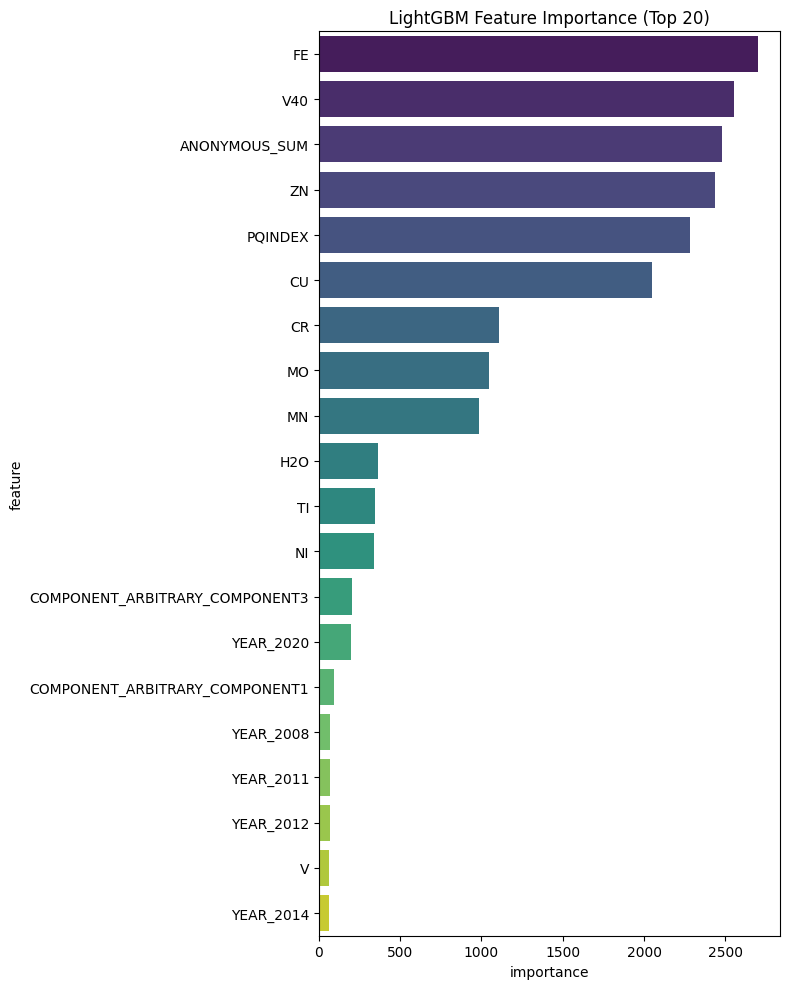

,feature,importance
3,FE,2701
11,V40,2555
13,ANONYMOUS_SUM,2481
12,ZN,2437
8,PQINDEX,2283
2,CU,2047
1,CR,1110
6,MO,1048
5,MN,987
4,H2O,365


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_27580\4273732353.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(top_n), palette="viridis")


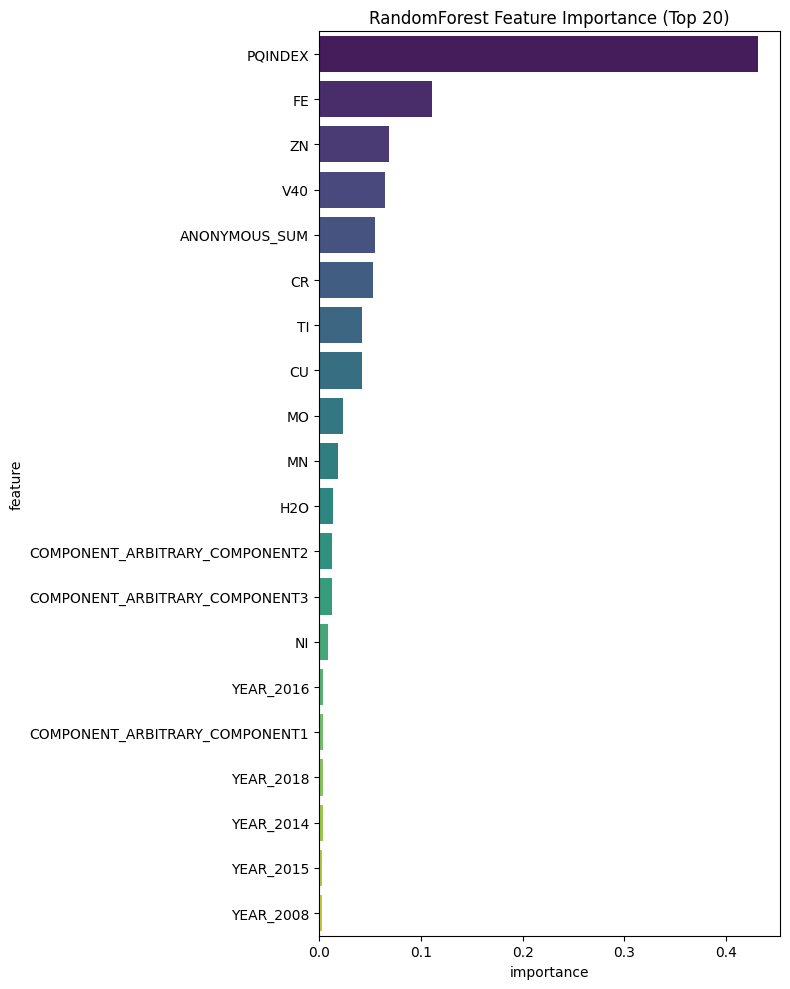

,feature,importance
7,PQINDEX,0.431178
2,FE,0.111317
10,ZN,0.068964
9,V40,0.065333
11,ANONYMOUS_SUM,0.055566
0,CR,0.052818
8,TI,0.042571
1,CU,0.041924
5,MO,0.023543
4,MN,0.018686


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_27580\4273732353.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(top_n), palette="viridis")


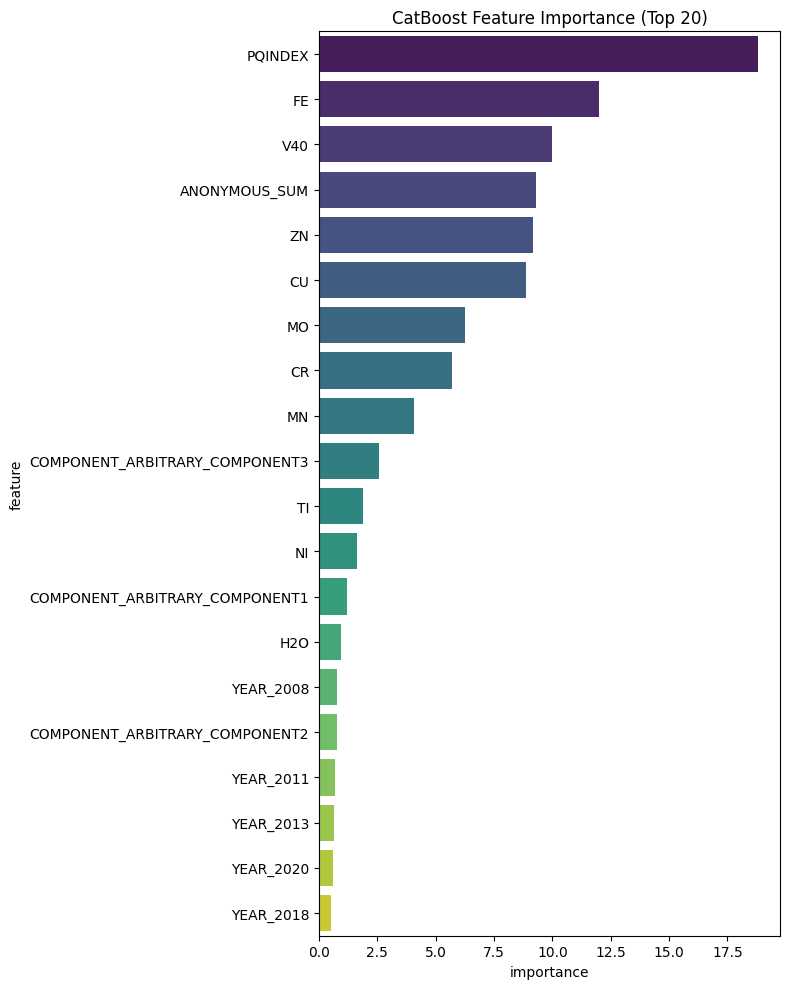

,feature,importance
8,PQINDEX,18.812689
3,FE,12.012771
11,V40,10.004328
13,ANONYMOUS_SUM,9.305673
12,ZN,9.170738
2,CU,8.878926
6,MO,6.259695
1,CR,5.701156
5,MN,4.061105
29,COMPONENT_ARBITRARY_COMPONENT3,2.583149


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_27580\4273732353.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(top_n), palette="viridis")


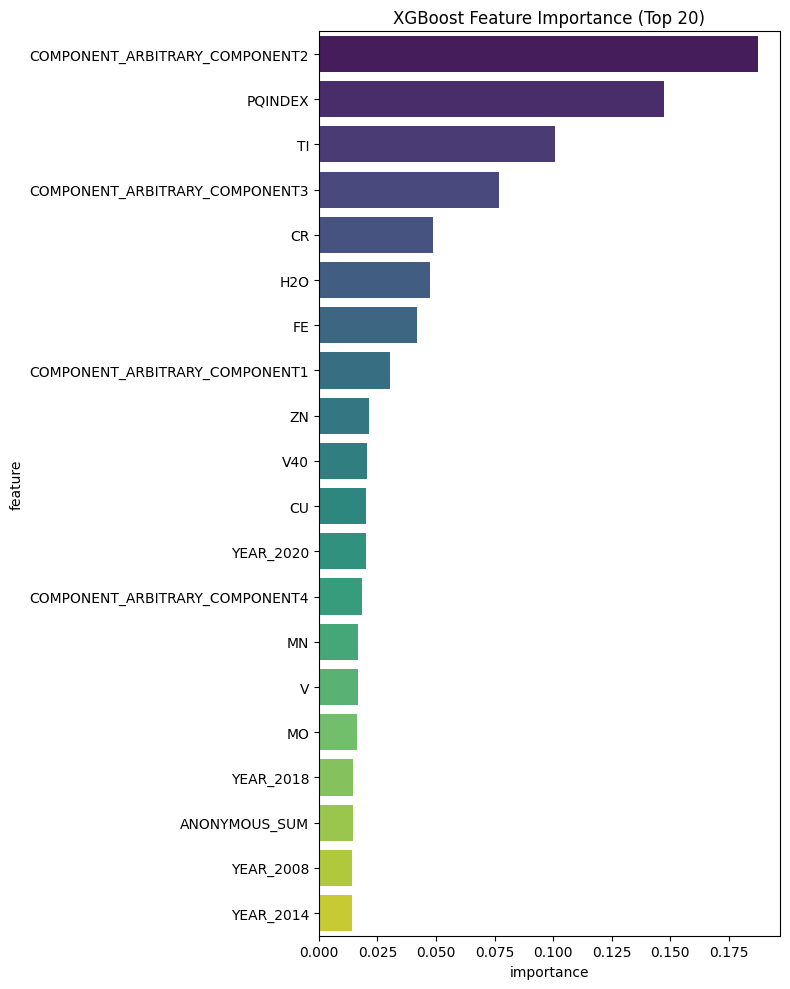

,feature,importance
26,COMPONENT_ARBITRARY_COMPONENT2,0.187427
6,PQINDEX,0.147437
7,TI,0.100830
27,COMPONENT_ARBITRARY_COMPONENT3,0.077022
0,CR,0.048600
3,H2O,0.047272
2,FE,0.041851
25,COMPONENT_ARBITRARY_COMPONENT1,0.030295
10,ZN,0.021295
9,V40,0.020696


C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_27580\4273732353.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df.head(top_n), palette="viridis")


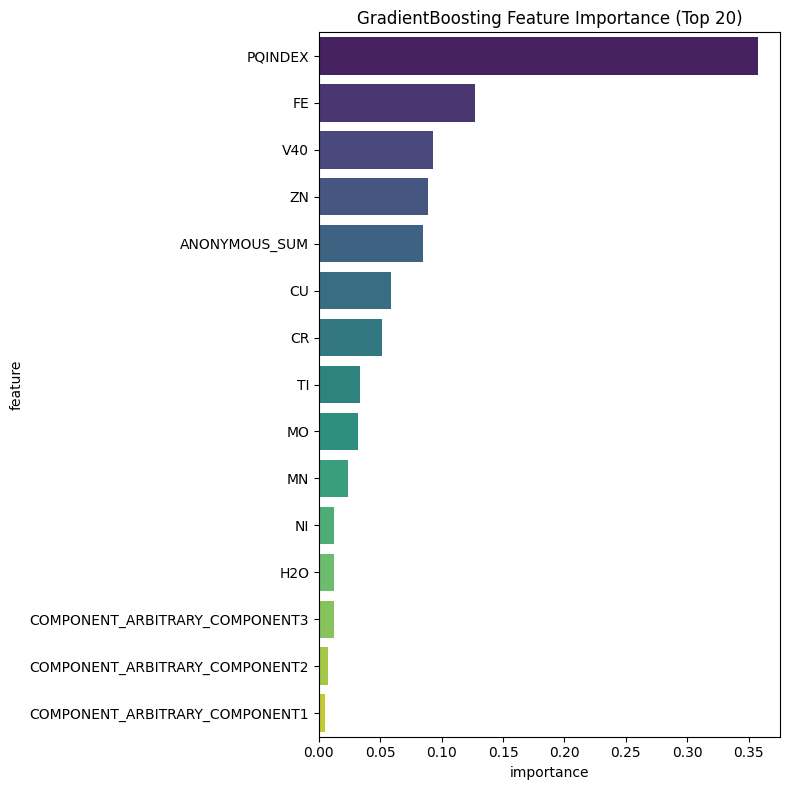

,feature,importance
7,PQINDEX,0.357634
2,FE,0.127437
9,V40,0.092712
10,ZN,0.089117
11,ANONYMOUS_SUM,0.085145
1,CU,0.058877
0,CR,0.051776
8,TI,0.033271
5,MO,0.031557
4,MN,0.023898


In [21]:
importances_dict = {}

def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """
    모델의 feature importance를 시각화하고, 중요도 순으로 출력합니다.
    model: 학습된 모델 객체
    feature_names: 특성 이름 리스트
    model_name: 모델 이름(str)
    top_n: 상위 n개만 시각화
    """
    # 트리 계열 모델은 feature_importances_ 속성 사용
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    # CatBoost는 get_feature_importance() 메서드도 지원
    elif hasattr(model, "get_feature_importance"):
        importances = model.get_feature_importance()
    else:
        print(f"{model_name}은 feature importance를 지원하지 않습니다.")
        return

    # 중요도 DataFrame 생성
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    importances_dict[model_name] = fi_df

    # 상위 n개만 시각화
    plt.figure(figsize=(8, min(top_n, len(fi_df)) * 0.4 + 2))
    sns.barplot(x="importance", y="feature", data=fi_df.head(top_n), palette="viridis")
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.tight_layout()
    plt.show()

    # 중요도 순 출력
    display(fi_df)

# 예시: 이미 학습된 모델과 feature 리스트를 사용
# LightGBM
plot_feature_importance(final_lgbm, lgbm_features, "LightGBM")

# RandomForest
plot_feature_importance(final_rf, rf_features, "RandomForest")

# CatBoost
plot_feature_importance(final_cat, cat_features, "CatBoost")

# XGBoost
plot_feature_importance(final_xgb, xgb_features, "XGBoost")

# GradientBoosting
plot_feature_importance(final_gb, gb_features, "GradientBoosting")

5개의 모델에서 가장 많이 활용된 변수를 확인하고자 특성 중요도를 확인했다.   
특성 중요도는 모델이 예측을 위해 각 독립 변수를 얼마나 많이 활용했는지를 수치로 나타낸 값이다. 이 값이 클수록 각 변수가 분할에 기여한 정도가 높다는 의미이다.   
확인한 결과 모델 저마다 feature importance 수치가 다르지만 공통적으로 FE, PQINDEX, V40, ZN 변수가 많이 활용되었다는 것을 알 수 있었다.    
FE는 IRON 함유량, ZN은 Zinc 함유량, PQINDEX는 Particle Quantifier Index, V40은 40도에서 측정한 액체의 점도를 나타낸다.    
이로써 오일 정상 여부를 확인하기 위해선 가장 우선으로 IRON, Zinc 함유량을 확인하고 Particle Quantifier Index, V40를 확인해볼 필요가 있다.   
실제로 Particle Quantifier Index 수치를 확인해보면 정상일 때보다 비정상일 때 중간값이 더 높았다. 그리고 v40의 경우에도 오일이 정상일 때와 비정상일 때의 수치 분포에서 미묘하지만 차이를 보였다.   
IRON 함유량의 경우 오일이 비정상일 때가 정상일 때보다 함유량이 더 많았다. ZN 함유량은 COMPONENT가 1,2,4 일 때 비정상과 정상 간의 차이가 크게 나타났었다.    

5개의 모델을 활용해 test_df에 대해 예측한 뒤, 5개의 예측값을 보팅기법을 활용해서 최종 예측 결과 도출하였다.

In [32]:
# 5개 모델의 submission 파일 불러오기
sub_lgbm = pd.read_csv("submission_lgbm.csv")
sub_rf = pd.read_csv("submission_rf.csv")
sub_cat = pd.read_csv("submission_cat.csv")
sub_xgb = pd.read_csv("submission_xgb.csv")
sub_gb = pd.read_csv("submission_gb.csv")

# ID 기준으로 정렬(혹시 순서가 다를 수 있으니)
sub_lgbm = sub_lgbm.sort_values("ID").reset_index(drop=True)
sub_rf = sub_rf.sort_values("ID").reset_index(drop=True)
sub_cat = sub_cat.sort_values("ID").reset_index(drop=True)
sub_xgb = sub_xgb.sort_values("ID").reset_index(drop=True)
sub_gb = sub_gb.sort_values("ID").reset_index(drop=True)

# 각 모델 예측값을 합쳐서 보팅(다수결)
voting = (
  sub_lgbm["Y_LABEL"] +
  sub_rf["Y_LABEL"] +
  sub_cat["Y_LABEL"] +
  sub_xgb["Y_LABEL"] +
  sub_gb["Y_LABEL"]
)

# 3개 이상이면 1, 아니면 0 (다수결)
final_pred = (voting >= 3).astype(int)

# 최종 결과 DataFrame 생성
submission_voting = sub_lgbm[["ID"]].copy()
submission_voting["Y_LABEL"] = final_pred

# 저장
submission_voting.to_csv("submission_voting.csv", index=False)

Dacon 기준    
public score: 0.8165002476    
private score: 0.8134227435